### Connection With Google Drive

In [16]:
## Start from this Cell
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
os.chdir('/content/drive/MyDrive/Watermark')

#custom Matrix (F1 Score) used And Installing other required Model related thing

In [18]:
def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    actual_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [19]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K
from segmentation_models.metrics import iou_score

In [21]:
# Register custom metrics
tf.keras.utils.get_custom_objects().update({'f1_score': f1_score,
                                            'dice_coefficient': dice_coefficient,
                                            'iou_score': iou_score})

### Importing Libraries and Loading the Model

In [22]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the segmentation model
model_path = '/content/drive/MyDrive/Watermark/resnet_unet.h5'
model = tf.keras.models.load_model(model_path)



# Adding Watermark
Model-->ROI and NROI--> Watermark ROI--> Combine NROI and watermarked ROI

### Segmentation Model to extract ROI

1/1 [==============================] - 1s 974ms/step


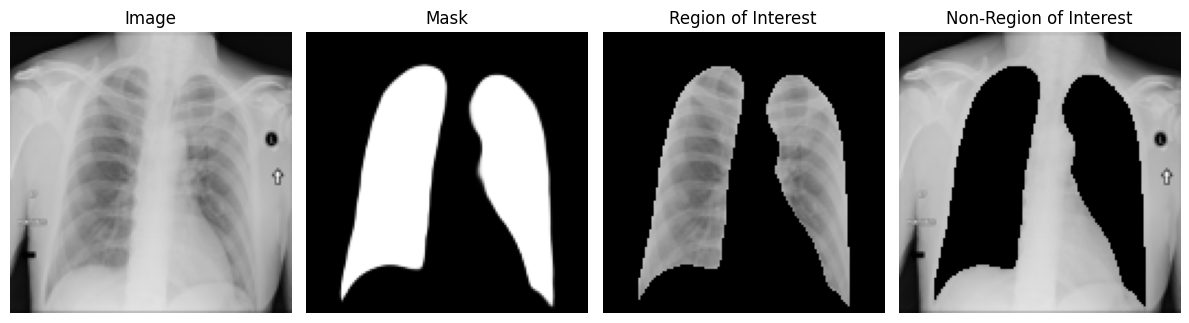

In [23]:
# Load the image
image_path = '/content/drive/MyDrive/Watermark/train-old/36200.png'
orignal_start_image = Image.open(image_path).convert('RGB')

# Resize the image to 128x128x3
resized_image = orignal_start_image.resize((128, 128))

# Convert the resized image to a numpy array and normalize
input_image = np.array(resized_image) / 255.0

# Preprocess the input image for the segmentation model
input_tensor = tf.expand_dims(input_image, axis=0)

# Get the predicted mask from the segmentation model
mask = model.predict(input_tensor)

# Squeeze the mask to remove the extra dimension
mask = np.squeeze(mask)

# Threshold the mask to convert it into a binary mask
threshold = 0.5
binary_mask = np.where(mask > threshold, 1, 0)

# Apply the binary mask to the original image to extract the region of interest (ROI)
roi = np.multiply(input_image, np.expand_dims(binary_mask, axis=-1))

# Calculate the non-region of interest (NROI) by subtracting the ROI from the original image
nroi = input_image - roi

# Convert the mask, ROI, and NROI to PIL Image format
mask_image = Image.fromarray((mask * 255).astype(np.uint8))
roi_image = Image.fromarray((roi * 255).astype(np.uint8))
nroi_image = Image.fromarray((nroi * 255).astype(np.uint8))

# Display the images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(input_image)
plt.title('Image')
plt.axis('off')

# Mask image
plt.subplot(1, 4, 2)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask')
plt.axis('off')

# ROI image
plt.subplot(1, 4, 3)
plt.imshow(roi_image)
plt.title('Region of Interest')
plt.axis('off')

# NROI image
plt.subplot(1, 4, 4)
plt.imshow(nroi_image)
plt.title('Non-Region of Interest')
plt.axis('off')

plt.tight_layout()
plt.show()


### Watermarking on Region of Intrest

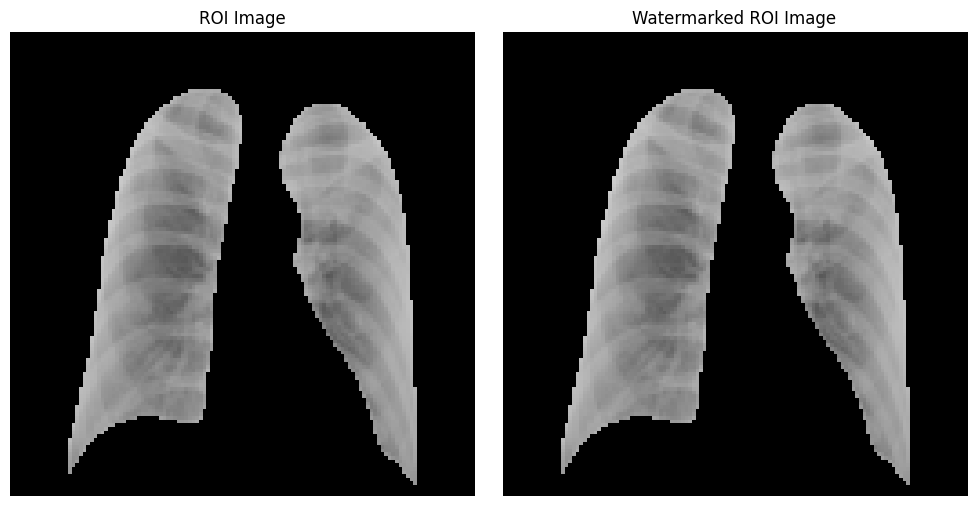

In [24]:
import numpy as np
from scipy.linalg import svd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Embedding parameters
alpha = 0.01  # Watermark strength
text_watermark = "hello"

# Create a copy of the ROI image to add the watermark
watermarked_roi_image = roi_image.copy()

# Define font properties for the text watermark
font_size = 10
font = ImageFont.load_default()

# Calculate the position to place the text watermark
text_width, text_height = font.getsize(text_watermark)
x = (roi_image.width - text_width) // 2
y = (roi_image.height - text_height) // 2

# Create a transparent image to hold the text watermark
text_image = Image.new('RGBA', (roi_image.width, roi_image.height), (0, 0, 0, 0))
draw = ImageDraw.Draw(text_image)
draw.text((x, y), text_watermark, font=font, fill=(0, 0, 0, 0))  # Set the text fill color with alpha

# Convert images to numpy arrays
watermarked_array = np.array(watermarked_roi_image)
text_array = np.array(text_image)

# Convert the watermarked ROI image to grayscale
watermarked_array_gray = watermarked_roi_image.convert('L')

# Perform Singular Value Decomposition (SVD) on the grayscale watermarked ROI image
U, s, Vt = svd(watermarked_array_gray, full_matrices=False)

# Modify singular values to embed the watermark
s_watermarked = s + alpha * s

# Reconstruct the watermarked ROI image
watermarked_array_gray = U.dot(np.diag(s_watermarked)).dot(Vt)

# Create the final watermarked ROI image by combining the ROI image with the text watermark
watermarked_roi_image = Image.fromarray(watermarked_array_gray).convert('RGB')
watermarked_roi_image.paste(text_image, mask=text_image)

# Display the original ROI image and watermarked ROI image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(roi_image)
plt.title('ROI Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(watermarked_roi_image)
plt.title('Watermarked ROI Image')
plt.axis('off')

plt.tight_layout()
plt.show()

### Combining the Watermarked ROI with NROI

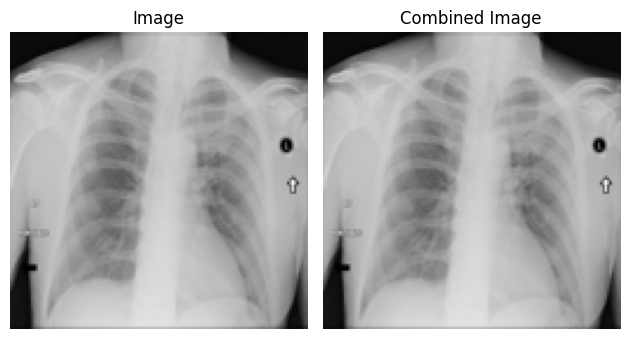

In [25]:
# Convert images to numpy arrays
nroi_array = np.array(nroi_image)
watermarked_roi_array = np.array(watermarked_roi_image)

# Combine the NROI image and the watermarked ROI image
combined_image = nroi_array + watermarked_roi_array

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Image')
plt.axis('off')

# Display the combined image
plt.subplot(1, 2, 2)
plt.imshow(combined_image)
plt.title('Combined Image')
plt.axis('off')

plt.tight_layout()
plt.show()


# Extracting Watermark
Model-->ROI and NROI--> Extract Text from ROI--> Combine NROI and and cleaned ROI

### Segmentation Model to extract ROI

1/1 [==============================] - 0s 91ms/step


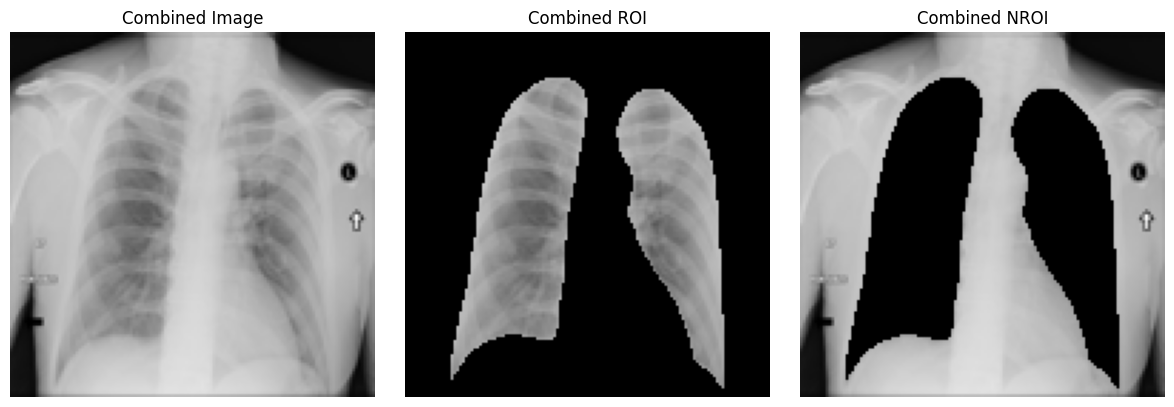

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the combined image to a numpy array and normalize
combined_array = np.array(combined_image) / 255.0

# Preprocess the input image for the segmentation model
input_tensor = tf.expand_dims(combined_array, axis=0)

combined_mask = model.predict(input_tensor)
# Squeeze the mask to remove the extra dimension
combined_mask = np.squeeze(combined_mask)

# Threshold the mask to convert it into a binary mask
threshold = 0.5
binary_mask = np.where(combined_mask > threshold, 1, 0)

# Apply the binary mask to the original image to extract the region of interest (ROI)
combined_roi = np.multiply(input_image, np.expand_dims(binary_mask, axis=-1))

# Calculate the non-region of interest (NROI) by subtracting the ROI from the original image
combined_nroi = input_image - combined_roi

# Convert the mask, ROI, and NROI to PIL Image format
mask_image = Image.fromarray((combined_mask * 255).astype(np.uint8))
combined_roi_image = Image.fromarray((combined_roi * 255).astype(np.uint8))
combined_nroi_image = Image.fromarray((combined_nroi * 255).astype(np.uint8))

# Display the images
plt.figure(figsize=(12, 4))

# Combined image
plt.subplot(1, 3, 1)
plt.imshow(combined_image)
plt.title('Combined Image')
plt.axis('off')

# ROI image
plt.subplot(1, 3, 2)
plt.imshow(combined_roi_image)
plt.title('Combined ROI')
plt.axis('off')

# NROI image
plt.subplot(1, 3, 3)
plt.imshow(combined_nroi_image)
plt.title('Combined NROI')
plt.axis('off')

plt.tight_layout()
plt.show()


## Extracting the watermark from ROI

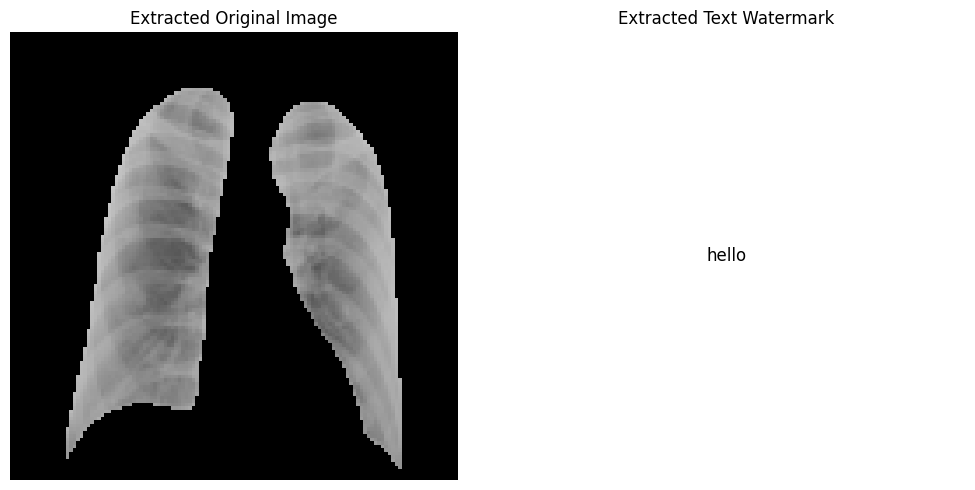

hello


In [27]:
# Convert the watermarked image to grayscale
watermarked_array_gray = combined_roi_image.convert('L')

# Perform Singular Value Decomposition (SVD) on the grayscale watermarked image
U_w, s_w, Vt_w = svd(watermarked_array_gray, full_matrices=True)

# Reverse the watermark embedding to extract the original singular values
s_original = s_w - alpha * s_w

# Reconstruct the original image
original_array_gray = U_w.dot(np.diag(s_original)).dot(Vt_w)

# Create the final original image by converting the array to Image
original_image = Image.fromarray(original_array_gray)

# Display the extracted text and the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Extracted Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, text_watermark, ha='center', va='center', fontsize=12)
plt.title('Extracted Text Watermark')
plt.axis('off')

plt.tight_layout()
plt.show()

print(text_watermark)

### Combine the NROI and ROI

(-0.5, 127.5, 127.5, -0.5)

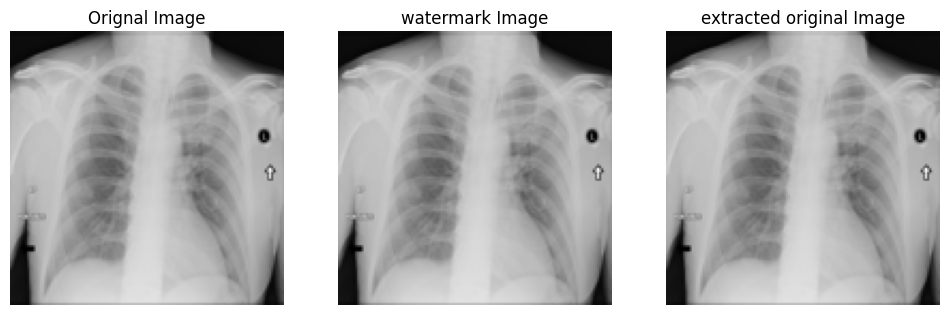

In [28]:
# Convert images to numpy arrays
nroi_array = np.array(combined_nroi_image)
original_image = original_image.convert('RGB')
original_array = np.array(original_image)

original_image = nroi_array+original_array

# Display the images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(resized_image)
plt.title('Orignal Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(combined_image)
plt.title('watermark Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_image)
plt.title('extracted original Image')
plt.axis('off')



In [38]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_watermark(original_image, extracted_image):
    # Convert images to numpy arrays
    original_image = np.array(original_image)
    extracted_image = np.array(extracted_image)

    # Calculate PSNR
    psnr = peak_signal_noise_ratio(original_image, extracted_image)

    # Calculate SSIM
    ssim = structural_similarity(original_image, extracted_image, multichannel=True)

    return psnr, ssim


In [39]:
# Load the original image and the extracted image
resized_image = orignal_start_image.resize((128, 128))
# Call the function to evaluate the watermarking
psnr, ssim = evaluate_watermark(resized_image,original_image)
# Print the results
print("PSNR:", psnr)
print("SSIM:", ssim)


PSNR: 47.15576991395285
SSIM: 0.9993498364995806


<ipython-input-38-ad1c52716b09>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(original_image, extracted_image, multichannel=True)
